In [1]:
# !usr/bin/python
# -*- encoding: utf-8 -*-
# Project: Sequence to Squence
# Author: Tracy Tao
# Date: 2022/04/13

- BOS: begining of sequence
- EOS: end of sequence
- 使用循环神经网络编码器最终的隐状态来初始化解码器的隐状态; 编码器最终的隐状态在每一个时间步都作为解码器的输入序列的一部分
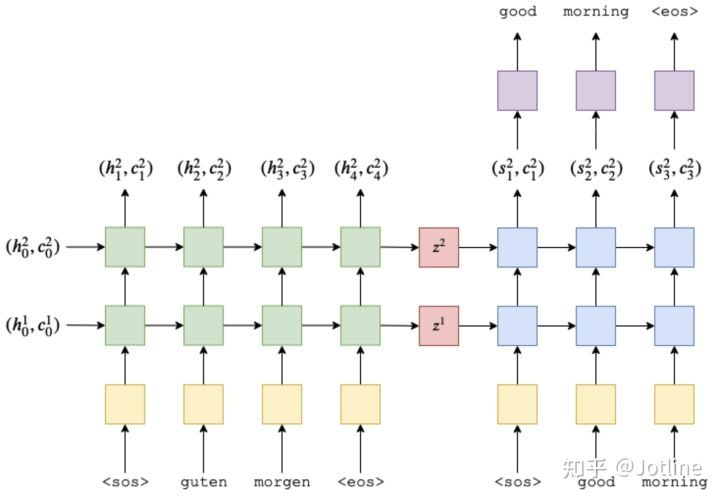

In [2]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class Seq2SeqEncoder(d2l.Encoder):
    '''
    Seq2Seq - RNNs - Encoder
    :params vocab_size: 输入的维度
    :params embed_size: 嵌入层维度
    :params num_hiddens: 隐藏单元的维度
    :params num_layers: 隐藏层数量
    :params dropout: 丢弃率
    '''
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs) 
        self.embedding = nn.Embedding(vocab_size, embed_size) # Embedding Layer
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout = dropout) # RNN - gru
    
    def forward(self, X, *args):
        X = self.embedding(X) # output X: (batch_size, num_steps, embed_size)
        X = X.permute(1, 0, 2) # 按照idx换位，第一个轴对应于时间步
        output, state = self.rnn(X) # 如果未提及状态，则默认为0
        # output : (num_steps, batch_size, num_hiddens) （时间步数，批量大小，隐藏单元数）
        # state[0] : (num_layers, batch_size, num_hiddens)
        return output, state

- 编码器:
    - 使用了嵌入层（embedding layer） 来获得输入序列中每个词元的特征向量。 嵌入层的权重是一个矩阵， 其行数等于输入词表的大小（vocab_size）， 其列数等于特征向量的维度（embed_size）。 
    - 对于任意输入词元的索引i， 嵌入层获取权重矩阵的第i行（从0开始）以返回其特征向量。 
    - 编码器—解码器（encoder-decoder）或者seq2seq模型。本质上都⽤到了**两个循环神经⽹络**，分别叫做编码器和解码器。**编码器⽤来分析输⼊序列，解码器⽤来⽣成输出序列**。两 个循环神经网络是共同训练的。

In [4]:
encoder = Seq2SeqEncoder(vocab_size = 10, embed_size = 8, num_hiddens = 16, num_layers = 2)
encoder.eval()

Seq2SeqEncoder(
  (embedding): Embedding(10, 8)
  (rnn): GRU(8, 16, num_layers=2)
)

In [5]:
X = torch.zeros((4,7), dtype= torch.long) # (batch_size, 时间步)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [6]:
class Seq2SeqDecoder(d2l.Decoder):
    '''
    Seq2Seq - RNNs - Decoder
    :params vocab_size: 输入的维度
    :params embed_size: 嵌入层维度
    :params num_hiddens: 隐藏单元的维度
    :params num_layers: 隐藏层数量
    :params dropout: 丢弃率
    '''
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout =0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout = dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size) 
    
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    
    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2) # out X: (batch_size,num_steps,embed_size)
        context = state[-1].repeat(X.shape[0], 1, 1) # 沿着各种维度复制数据
        X_and_context = torch.cat((X, context), 2) # 上下文变量在所有的时间步与解码器的输入进行拼接
        output, state = self.rnn(X_and_context, state) 
        # state[0]: (num_layers,batch_size,num_hiddens)
        output = self.dense(output).permute(1, 0, 2) # 使用原连接层来变换隐状态
        # output: (batch_size,num_steps,vocab_size)
        return output, state
        
        

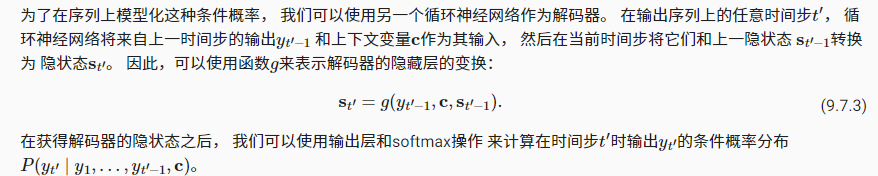
- 使用编码器最后一个时间步的隐状态来初始化解码器的隐状态。为了进一步包含经过编码的输入序列的信息， 上下文变量在所有的时间步与解码器的输入进行拼接（concatenate）。 为了预测输出词元的概率分布， 在循环神经网络解码器的最后一层使用全连接层来变换隐状态。

In [7]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()

Seq2SeqDecoder(
  (embedding): Embedding(10, 8)
  (rnn): GRU(24, 16, num_layers=2)
  (dense): Linear(in_features=16, out_features=10, bias=True)
)

In [8]:
state = decoder.init_state(encoder(X)) # 使用编码器最后一个时间步的隐状态来初始化解码器的隐状态

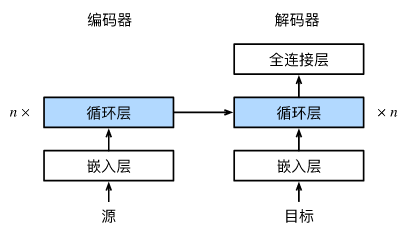
- 我们可以使用下面的sequence_mask函数 通过**零值化屏蔽不相关的项**， 以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。

- 每个时间步，Decoder预测输出词元的概率分布，类似于语言模型，可以使用softmax来获得分布，并通过计算交叉熵损失函数进行优化。

In [9]:
def sequence_mask(X, valid_len, value = 0):
    '''序列中屏蔽不相关的项'''
    maxLen = X.size(1)
    mask = torch.arange((maxLen), 
                        dtype = torch.float32,
                        device = X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [10]:
# 将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def forward(self, pred, label, valid_len):
        '''
        :params pred：(batch_size,num_steps,vocab_size)
        :params label：(batch_size,num_steps)
        :params valid_len：(batch_size,)
        '''
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction ='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [11]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [12]:
# train 
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    '''
    :param net: model
    :param data_iter: input
    :param lr: learning rate
    :param num_epochs: training epochs
    :param tgt_vocab: label
    :param device: cpu/gpu
    '''
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameter[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel = 'epoch', ylabel = 'loss',  xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad() # 初始化0梯度
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch] 
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device = device).reshape(-1,1)
            # 索引bos （Y.shape[0]）并且展平
            dec_input = torch.cat([bos, Y[:, :-1]], 1) # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len) # 损失函数
            l.sum().backward() # 反向传播
            d2l.grad_clipping(net, 1) # 梯度裁剪 
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}') 
            
    

https://wmathor.com/index.php/archives/1448/
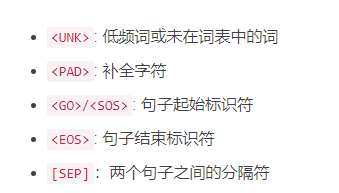

In [13]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab,
                    num_steps, device, save_attention_weights = False):
    '''
    :param net: model
    :param src_sentence: input sentence
    :param src_vocab: vocab
    :param tgt_vocab: label
    :param num_steps: 时间步
    :param device: torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    :param save_attention_weights: use attention or not
    '''
    net.eval() # 预测时设置为评估模式
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    # 将输出句子按空格切分 + eos标识符
    enc_valid_len = torch.tensor([len(src_tokens)], device = device)
    # 分词张量，即encoder的合法维度
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>']) 
    # truncate: 用时间步截断 + 并使用<pad>对应的字符padding
    
    # 添加encoder批量轴
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype = torch.long, device = device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len) # encoder的输出是decoder的初始化
    # 添加decoder批量轴
    dex_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype = torch.long, device = device),dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state) 
        dex_X = Y.argmax(dim=2) # 选取最高可能性的词元
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights:
            attenton_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq
        
    
    

In [14]:
# bleu评估
def bleu(pred_seq, label_seq, k):
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 -len_label /len_pred))
    for n in range(1, k+1):
        # defaultdict:当字典里的key不存在但被查找时，返回的不是keyError而是一个默认值
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score    